# PCA on High-Level Dimensions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import analysis_utils as au
import altair as alt
import plot
import pathlib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

In [3]:
try:
    df_raw = pd.read_csv('./data/super_experiment_design_space.csv')
    print(f"Successfully loaded raw dataset. Shape: {df_raw.shape}")
except FileNotFoundError:
    print("Error: './data/super_experiment_design_space.csv' not found.")

df_pca_features, numerical_cols, categorical_cols, df_processed, preprocessor = au.preprocess(df_raw, merge_conflict_dimensions=True)
print("\nPreprocessing complete.")
display(df_pca_features.head())
assert df_pca_features[df_pca_features.isnull().any(axis=1)].size == 0

Successfully loaded raw dataset. Shape: (405, 26)

Preprocessing complete.


,Task 2 Response Probability,Inter-task SOA,Distractor SOA,Task 1 CSI,Task 2 CSI,RSI,Switch Rate,Task 1 Difficulty,Task 2 Difficulty,Inter-task SOA is NA,Distractor SOA is NA,Task 2 CSI is NA,Task 2 Difficulty is NA,Response Set Overlap Mapped,RSI is Predictable,Inter-task SOA is Predictable,Task 1 Stimulus-Response Mapping Mapped,Task 1 Cue Type Mapped,Task 2 Stimulus-Response Mapping Mapped,Task 2 Cue Type Mapped,Trial Transition Type Mapped,Intra-Trial Task Relationship Mapped,SBC_Mapped
0,1.0,1875.0,0.0,0,0.0,1000.0,0.0,0.0,0.000000,0,1,0,0,RSO_Identical,1,No,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,N/A
1,1.0,3750.0,0.0,0,0.0,1000.0,0.0,0.5,0.500000,0,1,0,0,RSO_Identical,1,No,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,N/A
2,1.0,6200.0,0.0,0,0.0,1000.0,0.0,0.5,0.500000,0,1,0,0,RSO_Identical,1,No,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,N/A
3,0.0,150.0,0.0,0,0.0,1000.0,0.0,0.0,0.362007,1,1,1,1,RSO_NA,1,N/A,SRM_Compatible,TCT_Implicit,SRM2_NA,TCT2_NA,TTT_Pure,ITTR_NA,N/A
4,0.0,150.0,0.0,0,0.0,1000.0,0.0,0.0,0.362007,1,0,1,1,RSO_NA,1,N/A,SRM_Compatible,TCT_Implicit,SRM2_NA,TCT2_NA,TTT_Pure,ITTR_NA,Incongruent


### Exploratory Data Analysis

In [4]:
# List of the original categorical columns we want to inspect
categorical_columns_to_explore = [
    'Response Set Overlap',
    #'Stimulus-Stimulus Congruency',
    #'Stimulus-Response Congruency',
    'Stimulus Bivalence & Congruency',
    'Task 1 Stimulus-Response Mapping',
    'Task 1 Cue Type',
    'Task 2 Stimulus-Response Mapping',
    'Task 2 Cue Type'
]
numeric_columns_to_explore = [
    'Inter-task SOA',
    'Distractor SOA',
    'Task 1 CSI',
    'Task 2 CSI', 
    'Task 2 Difficulty'
]

# Loop through the columns and print their value counts
for col in categorical_columns_to_explore:
    print(f"\nValue counts for column: '{col}'")
    # Use dropna=False to explicitly see the count of any missing values (NaNs)
    print(df_processed[col].value_counts(dropna=False))
    print("-" * 30)

print("-" * 60)
print("Review the counts above. If a sub-category has very few examples (e.g., < 5-10),")
print("it is generally better to collapse it into a broader category for the PCA.")
print("This analysis should guide the modifications to the mapping functions in Stage 3.")

for col in numeric_columns_to_explore:
    print(col, au.check_skewness(df_processed[col]))

print("-" * 60)
print("Review the skewness of the numeric columns. If they are skewed it'll be better to")
print("impute with the median instead of the mean.")


Value counts for column: 'Response Set Overlap'
Response Set Overlap
Identical                              134
NaN                                    124
Disjoint - Effector                     77
Disjoint - Modality                     32
Disjoint - Category (Same Modality)     23
Disjoint - Modality (Standard)           8
Disjoint - Modality (Non-Standard)       7
Name: count, dtype: int64
------------------------------

Value counts for column: 'Stimulus Bivalence & Congruency'
Stimulus Bivalence & Congruency
Incongruent    122
Neutral        112
N/A             88
Congruent       83
Name: count, dtype: int64
------------------------------

Value counts for column: 'Task 1 Stimulus-Response Mapping'
Task 1 Stimulus-Response Mapping
Arbitrary       227
Compatible      174
Incompatible      4
Name: count, dtype: int64
------------------------------

Value counts for column: 'Task 1 Cue Type'
Task 1 Cue Type
None/Implicit    299
Arbitrary        106
Name: count, dtype: int64
--------

## PCA Fitting

In [5]:
pipeline = au.create_pca_pipeline(numerical_cols, categorical_cols)
pipeline.fit(df_pca_features)
pca_results = pipeline.transform(df_pca_features)
column_names = [f'PC{i+1}' for i in range(pca_results.shape[1])]

# 5. Create a Pandas DataFrame with the specified column names
pca_df = pd.DataFrame(pca_results, columns=column_names)
print("PCA pipeline fitted successfully.")

PCA pipeline fitted successfully.



--- Explained Variance ---
PC1: Explained Variance = 0.205, Cumulative Variance = 0.205
PC2: Explained Variance = 0.164, Cumulative Variance = 0.369
PC3: Explained Variance = 0.114, Cumulative Variance = 0.483
PC4: Explained Variance = 0.092, Cumulative Variance = 0.575
PC5: Explained Variance = 0.066, Cumulative Variance = 0.641
PC6: Explained Variance = 0.058, Cumulative Variance = 0.699
PC7: Explained Variance = 0.054, Cumulative Variance = 0.754
PC8: Explained Variance = 0.040, Cumulative Variance = 0.794
PC9: Explained Variance = 0.035, Cumulative Variance = 0.829
PC10: Explained Variance = 0.026, Cumulative Variance = 0.855
PC11: Explained Variance = 0.020, Cumulative Variance = 0.875
PC12: Explained Variance = 0.019, Cumulative Variance = 0.894
PC13: Explained Variance = 0.017, Cumulative Variance = 0.911
PC14: Explained Variance = 0.015, Cumulative Variance = 0.926
PC15: Explained Variance = 0.014, Cumulative Variance = 0.940
Successfully wrote LaTeX content for PC1 to report_

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48
Task 2 Response Probability,0.248,-0.424,0.311,-0.078,0.155,0.001,-0.284,0.003,-0.043,0.107,0.019,-0.197,-0.097,-0.091,0.088,-0.017,-0.226,-0.242,0.018,-0.070,-0.054,-0.003,0.060,0.077,0.426,-0.019,0.296,0.216,0.063,0.114,0.109,-0.027,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000
Inter-task SOA,0.096,-0.189,0.178,-0.162,0.273,-0.565,0.670,-0.136,0.013,0.060,-0.016,0.041,-0.006,0.043,-0.031,0.041,0.086,0.012,0.002,0.075,0.074,-0.031,0.059,0.031,0.034,-0.004,0.008,-0.023,-0.011,0.001,0.007,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000
Distractor SOA,-0.021,0.087,-0.225,0.108,0.829,0.226,0.036,0.331,-0.178,0.032,0.146,0.079,0.032,0.034,-0.006,-0.066,0.009,0.082,-0.033,-0.029,-0.020,-0.007,0.030,-0.007,0.014,0.001,0.026,0.049,-0.002,0.007,0.012,0.001,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000
Task 1 CSI,0.026,0.405,0.484,-0.077,0.012,-0.075,-0.071,0.133,0.014,-0.114,0.283,-0.030,-0.261,-0.173,0.213,-0.368,0.220,0.019,-0.204,0.289,-0.107,-0.034,0.059,-0.006,-0.010,-0.025,-0.040,0.029,-0.010,-0.005,0.012,-0.001,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000
Task 2 CSI,0.102,0.430,0.406,0.048,0.007,-0.202,-0.115,0.248,-0.068,-0.006,0.145,0.009,0.195,0.175,-0.180,0.476,-0.103,-0.014,0.171,-0.324,0.117,-0.009,-0.074,0.050,0.004,0.020,0.041,-0.014,0.010,0.012,-0.017,-0.006,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
RSI,-0.121,0.083,0.394,-0.232,0.061,0.595,0.280,-0.395,-0.319,-0.004,-0.153,0.151,-0.006,-0.015,-0.009,0.050,-0.007,-0.004,0.067,-0.099,0.046,0.069,-0.053,0.019,0.025,-0.015,0.012,-0.017,-0.009,-0.009,-0.009,0.003,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000
Switch Rate,0.369,0.226,-0.116,0.028,-0.108,0.281,0.343,0.089,0.364,0.478,0.154,-0.111,-0.158,-0.027,0.130,0.029,-0.161,-0.159,0.045,-0.060,0.085,0.037,0.016,-0.247,0.066,-0.006,-0.066,0.033,-0.056,-0.044,0.027,0.014,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000
Task 1 Difficulty,-0.148,-0.215,0.243,0.476,-0.245,0.033,0.229,0.492,-0.262,0.269,-0.263,0.165,0.013,-0.082,0.082,-0.082,0.026,0.028,-0.123,-0.058,-0.079,0.064,0.032,0.020,-0.024,0.030,0.010,-0.001,0.021,0.006,0.009,0.008,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000
Task 2 Difficulty,-0.054,-0.149,0.152,0.683,0.059,0.089,0.142,-0.312,0.166,-0.319,0.396,-0.055,-0.060,0.021,-0.002,0.001,-0.184,-0.032,0.105,-0.008,0.010,-0.082,-0.047,0.012,-0.069,-0.007,-0.016,-0.008,-0.004,-0.007,-0.050,-0.008,-0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000
Inter-task SOA is NA_0,0.101,-0.169,0.129,-0.058,0.056,0.031,-0.074,0.036,0.031,0.005,0.018,-0.107,0.052,0.040,-0.043,-0.034,0.007,-0.030,-0.083,0.031,0.214,0.294,0.002,-0.121,-0.466,0.033,0.071,0.143,0.032,-0.049,-0.090,-0.002,0.547,-0.038,-0.040,0.111,0.040,0.067,0.076,-0.140,0.127,0.055,0.053,-0.123,-0.000,0.009,-0.292,0.176


Sparseness of top 3 loadings: 0.3494542333472687


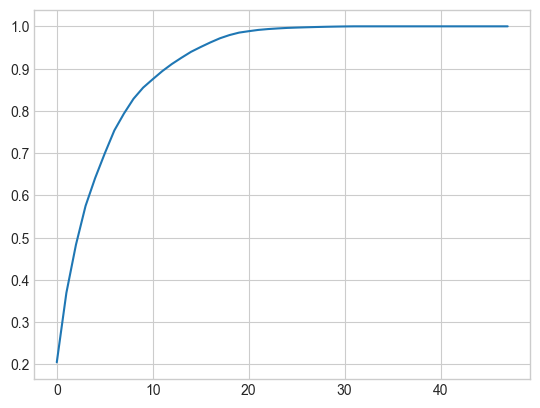

In [6]:
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\n--- Explained Variance ---")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    if cum_var > 0.95: break
    print(f"PC{i+1}: Explained Variance = {var:.3f}, Cumulative Variance = {cum_var:.3f}")

plt.plot(range(len(cumulative_variance)), cumulative_variance)
with open("report_data/cumulative_variance.tsv", 'w') as cumulative_variance_file:
    cumulative_variance_file.write("PC\tcum_var\n")
    cumulative_variance_file.write("0\t0\n")
    [cumulative_variance_file.write(f"{i+1}\t{cum_var*100}\n") for i, cum_var in enumerate(cumulative_variance) if cum_var < 0.9995]
    
loadings = au.get_component_loadings(pipeline, numerical_cols, categorical_cols)
for pc in ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12"]:
    au.export_component_loadings(loadings, pc, {}, f"report_data/{pc}.txt", 12)

print("\n--- Principal Component Loadings ---")
display(loadings.round(3))
print("Sparseness of top 3 loadings:", np.mean(au.get_loadings_sparseness(loadings.to_numpy()[:,:3])))

### Top weights for the first four components

In [7]:
display(loadings["PC1"].sort_values(key=abs, ascending=False).round(3)[:16])

Switch Rate                                               0.369
Task 2 Response Probability                               0.248
Task 2 Difficulty is NA_1                                -0.248
Task 2 Stimulus-Response Mapping Mapped_SRM2_NA          -0.248
Task 2 Cue Type Mapped_TCT2_NA                           -0.248
Task 2 Difficulty is NA_0                                 0.248
Task 2 CSI is NA_1                                       -0.246
Task 2 CSI is NA_0                                        0.246
Response Set Overlap Mapped_RSO_NA                       -0.244
Intra-Trial Task Relationship Mapped_ITTR_NA             -0.240
Intra-Trial Task Relationship Mapped_ITTR_Different       0.217
Task 2 Cue Type Mapped_TCT2_Implicit                      0.199
Trial Transition Type Mapped_TTT_Pure                    -0.194
Task 2 Stimulus-Response Mapping Mapped_SRM2_Arbitrary    0.187
Task 1 Difficulty                                        -0.148
Response Set Overlap Mapped_RSO_Disjoint

In [8]:
display(loadings["PC2"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 2 CSI                               0.430
Task 2 Response Probability             -0.424
Task 1 CSI                               0.405
Switch Rate                              0.226
Task 1 Difficulty                       -0.215
Inter-task SOA                          -0.189
Inter-task SOA is Predictable_N/A        0.180
Inter-task SOA is NA_0                  -0.169
Inter-task SOA is NA_1                   0.169
Trial Transition Type Mapped_TTT_Pure   -0.155
Task 2 Difficulty                       -0.149
Task 1 Cue Type Mapped_TCT_Implicit     -0.142
Task 1 Cue Type Mapped_TCT_Arbitrary     0.142
Task 2 Cue Type Mapped_TCT2_Arbitrary    0.142
Task 2 Cue Type Mapped_TCT2_Implicit    -0.138
Inter-task SOA is Predictable_Yes       -0.123
Name: PC2, dtype: float64

In [9]:
display(loadings["PC3"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 1 CSI                               0.484
Task 2 CSI                               0.406
RSI                                      0.394
Task 2 Response Probability              0.311
Task 1 Difficulty                        0.243
Distractor SOA                          -0.225
Inter-task SOA                           0.178
Task 2 Difficulty                        0.152
Inter-task SOA is NA_1                  -0.129
Inter-task SOA is NA_0                   0.129
Distractor SOA is NA_0                  -0.123
Distractor SOA is NA_1                   0.123
Switch Rate                             -0.116
Inter-task SOA is Predictable_N/A       -0.115
Trial Transition Type Mapped_TTT_Pure    0.112
SBC_Mapped_Neutral                      -0.103
Name: PC3, dtype: float64

In [10]:
display(loadings["PC4"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 2 Difficulty                                          0.683
Task 1 Difficulty                                          0.476
RSI                                                       -0.232
Task 1 Stimulus-Response Mapping Mapped_SRM_Compatible     0.167
Inter-task SOA                                            -0.162
Task 1 Stimulus-Response Mapping Mapped_SRM_Arbitrary     -0.157
Distractor SOA is NA_0                                     0.129
Distractor SOA is NA_1                                    -0.129
Task 2 Cue Type Mapped_TCT2_Arbitrary                      0.112
Distractor SOA                                             0.108
Intra-Trial Task Relationship Mapped_ITTR_Different        0.105
Task 1 Cue Type Mapped_TCT_Implicit                       -0.099
Task 1 Cue Type Mapped_TCT_Arbitrary                       0.099
Task 2 Response Probability                               -0.078
Task 1 CSI                                                -0.077
Task 2 Stimulus-Response 

### Find Centroids of Paradigms and Interpolate Them

### Plot Experimental Conditions

In [15]:
# --- 5. Define Tooltip Columns ---
tooltip_cols = [
    alt.Tooltip('Experiment:N', title='Experiment'),
    alt.Tooltip('Paradigm:N', title='Paradigm Class'),
    alt.Tooltip('Task 2 Response Probability:Q', title='T2 Response Probability', format='.2f'),
    alt.Tooltip('Inter-task SOA:N', title='Inter-task SOA'),
    alt.Tooltip('Inter-task SOA is Predictable:N', title='Inter-task SOA Predictable'),
    alt.Tooltip('Distractor SOA:N', title='Distractor SOA'),
    alt.Tooltip('Task 1 CSI:Q', title='T1 CSI', format='.0f'),
    alt.Tooltip('Task 2 CSI:Q', title='T2 CSI', format='.0f'),
    alt.Tooltip('RSI:Q', title='RSI', format='.0f'),
    alt.Tooltip('RSI is Predictable:N', title='RSI Predictable'),
    alt.Tooltip('Switch Rate:Q', title='Switch Rate (%)', format='.1f'),
    alt.Tooltip('Trial Transition Type:N', title='Transition Type'),
    alt.Tooltip('Stimulus Bivalence & Congruency:N', title='Stimulus Bivalence & Congruency'),
    alt.Tooltip('Response Set Overlap:N', title='Response Set Overlap'),
    alt.Tooltip('Task 1 Stimulus-Response Mapping:N', title='T1 Stimulus-Response Mapping'),
    alt.Tooltip('Task 2 Stimulus-Response Mapping:N', title='T2 Stimulus-Response Mapping'),
    alt.Tooltip('Task 1 Difficulty:Q', title='T1 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 Difficulty:Q', title='T2 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 CSI is NA:N', title='T2 CSI is N/A'),
    alt.Tooltip('Task 2 Difficulty is NA:N', title='T2 Difficulty is N/A'),
    alt.Tooltip('Inter-task SOA is NA:N', title='Inter-task SOA is N/A'),
    alt.Tooltip('Distractor SOA is NA:N', title='Distractor SOA is N/A')
]
# --- 1. Combine data and calculate centroids ---
plot_df = pd.concat([
    df_processed.reset_index(drop=True),
    pca_df.reset_index(drop=True)
], axis=1)
plot_df['Point Type'] = 'Empirical Data'

centroids_df = au.find_centroids(plot_df[[c for c in plot_df.columns if c.startswith("PC")] + ["Paradigm"]], paradigm_col='Paradigm')
centroids_df = pd.DataFrame.from_dict(centroids_df, orient='index').reset_index()
centroids_df = centroids_df.rename(columns={'index': 'Paradigm'})
centroids_df['Point Type'] = 'Centroid'

# --- 2. Generate interpolated points using the new utility function ---
interpolation_pairs = [
    ('Dual-Task_PRP', 'Task Switching'),
    ('Dual-Task_PRP', 'Interference'),
    ('Task Switching', 'Interference')
]

model_artifacts_pca = {'type': 'pca', 'pipeline': pipeline}

interpolated_df = au.generate_interpolated_points(
    latent_space_df=plot_df,
    model_artifacts=model_artifacts_pca,
    interpolation_pairs=interpolation_pairs
)

# --- 3. Combine all dataframes for plotting ---
final_plot_df = pd.concat([plot_df, centroids_df, interpolated_df], ignore_index=True)
final_plot_df['Parent1'] = final_plot_df['Parent1'].fillna('N/A')
final_plot_df['Parent2'] = final_plot_df['Parent2'].fillna('N/A')
#final_plot_df = plot.add_na_mask_from_flag(final_plot_df)

# Now, call the plotting function from plot.py
# (Assuming you have also moved the plotting logic there)
pca_chart = plot.create_latent_space_plot(final_plot_df, "PC1", "PC2", "PC1 (Procedural Stability <-> Dynamic Coordination)",
                                          "PC2 (Reactive Dual-Task Coordination vs. Proactive Preparation)",
                                          "Cognitive Control Experimental Conditions", tooltip_cols,
                                          has_interpolation=True, output_filename="pca_plot.json")#, highlight_conditions=["Hirsch et al. (2017) Experiment 2 Repeat 50ms SOA", "Röttger and Haider (2017) Experiment 3b 100ms SOA Green Box"])
pca_chart

   Task 2 Response Probability  Inter-task SOA  Distractor SOA  Task 1 CSI  \
0                 4.851485e-01      275.222772        7.502225  118.291801   
1                 4.851485e-01      275.222772        6.650165   79.654436   
2                 8.326673e-17      150.000000       17.518727  148.441287   

     Task 2 CSI          RSI  Switch Rate  Task 1 Difficulty  \
0  9.353933e+01  1167.335021    33.602014           2.326705   
1 -1.563194e-13  1569.650068    10.326733           2.499733   
2  9.353933e+01  1418.371227    23.275281           2.380893   

   Task 2 Difficulty  Inter-task SOA is NA  Distractor SOA is NA  \
0           2.458199                     1                     0   
1           2.471539                     1                     0   
2           2.434688                     1                     0   

   Task 2 CSI is NA  Task 2 Difficulty is NA Response Set Overlap Mapped  \
0                 0                        0                RSO_Disjoint   
1    

alt.LayerChart(...)

#### Sparseness Measure of first four PCs (to match MOFA+'s number of factors)

In [12]:
np.mean(au.get_loadings_sparseness(loadings[["PC1", "PC2", "PC3", "PC4"]].to_numpy()))

0.374496404620125

#### Paradigm Separation Validation

In [13]:
paradigm_separation_results = au.validate_paradigm_separation(plot_df, ["PC1", "PC2"], target_col='Paradigm', repeats=50)
print(paradigm_separation_results['accuracy'])

0.9752941176470589
